#3: Deep Learning Models for Speech Recognition
# Data Science - Capstone Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **29th October 2021 @ 21:30 BST**
* Instructor name: **Jeff Herman / James Irving**
* Blog URL: **https://toopster.github.io/**

---

## Table of Contents
1. [Business Case, Project Purpose and Approach](1_business_case.ipynb#business-case)
    1. [The importance of communication for people with severe learning disabilities](1_business_case.ipynb.ipynb#communication-and-learning-disabilities)
    2. [Types of communication](1_business_case.ipynb.ipynb#types-of-communication)
    3. [Communication techniques for people with learning disabilities](1_business_case.ipynb.ipynb#communication-techniques)
    4. [Project purpose & approach](1_business_case.ipynb.ipynb#project-purpose)
2. [Exploratory Data Analysis](2_eda.ipynb#eda)
    1. [The Datasets](2_eda.ipynb#the-datasets)
    2. [Discovery](2_eda.ipynb#data-discovery)
    3. [Preprocessing - Stage One](2_eda.ipynb#data-preprocessing-stage-one)
3. [Deep Learning Models for Speech Recognition](#deep-learning-models)
    1. [Preprocessing - Stage Two](#data-preprocessing-stage-two)
    2. [Model 1: Create a baseline model](#model-1)
    2. [Model 2: Baseline model with increased learning rate and batch size](#model-2)
    3. [Model 3: Adding hidden layers to the baseline model, deepening the network](#model-3)
    4. [Model 4: Convolutional Neural Network Model](#model-4)
    5. [Final Model Performance Evaluation](#final-model-performance-evaluation)

---
<a name="deep-learning-models"></a>
# 3. Deep Learning Models for Speech Recognition

In [1]:
# Import relevant libraries and modules for creating and training neural networks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import soundfile as sf
import librosa, librosa.display
import IPython.display as ipd
import os
import json

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pathlib
from pathlib import Path

In [2]:
# Set seed for reproducibility
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

<a name="data-preprocessing-stage-two"></a>
### 3A. Preprocessing - Stage Two

In [64]:
# Function to extract Mel Spectrograms and MFCCs to use in the models and store in JSON file
def preprocess_dataset(dataset_path, json_path, feature, num_samples, num_mfcc=13, n_fft=2048, hop_length=512):
    '''
    Extract Mel Spectrograms and MFCCs to use in the models and store in JSON file
        
        Params:
            dataset_path (str): Path to dataset containing audio samples
            feature (str): Specific feature requested, accepts either 'MFCCs' or 'mel_specs'
            json_path (str): Output path to JSON file
            num_samples (int):
            num_mfcc (int):
            n_fft (int):
            hop_length (int):
    '''     
    # Dictionary to temporarily store mapping, labels, MFCCs and filenames
    if feature == 'mel_specs':
        data = {
            'mapping': [],
            'labels': [],
            'mel_specs': [],
            'files': []
        }
    else:
         data = {
            'mapping': [],
            'labels': [],
            'MFCCs': [],
            'files': []
        }       

    # Loop through all sub directories
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # Ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # Save label in the mapping
            label = dirpath.split('/')[-1]
            data['mapping'].append(label)
            print("\nProcessing: '{}'".format(label))

            # Process all audio files in the sub directory and store MFCCs and Mel Spectrograms
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # Load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)

                # Drop audio files with less than pre-decided number of samples
                if len(signal) >= num_samples:

                    # Ensure consistency of the length of the signal
                    signal = signal[:num_samples]

                    # Extract MFCCs
                    if feature == 'mel_specs':
                        mel_specs = librosa.feature.melspectrogram(signal,
                                                                   sample_rate,
                                                                   n_fft=n_fft,
                                                                   hop_length=hop_length)

                        data['mel_specs'].append(mel_specs.T.tolist())
                        
                    else:
                        MFCCs = librosa.feature.mfcc(signal, 
                                                 sample_rate, 
                                                 n_mfcc=num_mfcc, 
                                                 n_fft=n_fft,
                                                 hop_length=hop_length)

                        data['MFCCs'].append(MFCCs.T.tolist())
                    
                    # Append data in dictionary
                    data['labels'].append(i-1)
                    data['files'].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    # Save data in JSON file for re-using later
    with open(json_path, 'w') as file_path:
        json.dump(data, file_path, indent=4)

In [4]:
# Set the parameters for the Speech Commands dataset for preprocessing
sc_dataset_path = 'data/speech_commands_v0.02'
sc_json_path = 'speech_commands_data.json'
num_samples = 22050

In [ ]:
# Preprocess the Speech Commands dataset
preprocess_dataset(sc_dataset_path, sc_json_path, 'MFCCs', num_samples)

In [5]:
# Set the parameters for the Ultrasuite dataset for preprocessing
us_dataset_path = 'data/ultrasuite_top35'
us_json_path = 'ultrasuite_top35_data.json'
num_samples = 22050

In [ ]:
# Preprocess the Ultrasuite dataset
preprocess_dataset(us_dataset_path, us_json_path, 'MFCCs', num_samples)

In [7]:
def load_data(data_path, feature):
    '''
    Load the data from the JSON file depending on selected feature
        
        Params:
            data_path (str): Path to json file containing data
            feature (str): Specific feature requested, accepts either 'MFCCs' or 'mel_specs'
            
        Returns:
            X (ndarray): Inputs
            y (ndarray): Targets
    ''' 
    with open(data_path, 'r') as file_path:
        data = json.load(file_path)

    X = np.array(data[feature])
    y = np.array(data['labels'])

    print('Datasets loaded...')
    
    return X, y

In [8]:
def create_train_test(data_path, feature, test_size=0.2, val_size=0.2):
    '''
    Splits the data to create training, test and validation datasets
        
        Params:
            data_path (str): Path to json file containing data
            feature (str): Specific feature requested, accepts either 'MFCCs' or 'mel_specs'
            test_size (float): Test size percentage
            val_size (float): Validation size percentage
            
        Returns:
            X_train (ndarray): Inputs for the training dataset
            y_train (ndarray): Targets for the training dataset
            X_val (ndarray): Inputs for the validation dataset
            y_val (ndarray): Targets for the validation dataset
            X_test (ndarray): Inputs for the test dataset
            y_test (ndarray): Targets for the test dataset
    ''' 
    # Load dataset
    X, y = load_data(data_path, feature)

    # Create train, test and validation splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

    # Increase the dimension of the array for each split
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
def visualise_results(results):
    '''
    Visualise the results from the model history plotting training / validation accuracy and loss vs. epoch
        
        Params:
            results: Model history
    '''     
    history = results.history

    plt.figure(figsize=(20,8))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'], fontsize=12)
    plt.title('Loss', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'], fontsize=12)
    plt.title('Accuracy', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

In [10]:
# Create the train, test and validation datasets for the Speech Commands dataset using MFCCs
sc_data_path = 'speech_commands_data.json'
sc_X_train, sc_y_train, sc_X_val, sc_y_val, sc_X_test, sc_y_test = create_train_test(sc_data_path, 'MFCCs')

Datasets loaded...


In [12]:
# Create the train, test and validation datasets for the Ultrasuite Top 35 dataset using MFCCs
us_data_path = 'ultrasuite_top35_data.json'
us_X_train, us_y_train, us_X_val, us_y_val, us_X_test, us_y_test = create_train_test(us_data_path, 'MFCCs')

Datasets loaded...


In [13]:
def check_array_shapes(X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Output the training, test and validation dataset shapes
        
        Params:
            X_train (ndarray): Inputs for the training dataset
            y_train (ndarray): Targets for the training dataset
            X_val (ndarray): Inputs for the validation dataset
            y_val (ndarray): Targets for the validation dataset
            X_test (ndarray): Inputs for the test dataset
            y_test (ndarray): Targets for the test dataset
    '''       
    print ("Number of training samples: " + str(X_train.shape[0]))
    print ("Number of testing samples: " + str(X_test.shape[0]))
    print ("Number of validation samples: " + str(X_val.shape[0]))
    print ("X_train shape: " + str(X_train.shape))
    print ("y_train shape: " + str(y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("y_test shape: " + str(y_test.shape))
    print ("X_val shape: " + str(X_val.shape))
    print ("y_val shape: " + str(y_val.shape))

In [14]:
def reformat_y(y):
    '''
    Reformats / One Hot Encodes targets
        
        Params:
            y (ndarray): Input targets
        
        Returns:
            y (ndarray): One hot encoded targets
    '''       
    y = LabelEncoder().fit_transform(y)
    y = tf.keras.utils.to_categorical(y)
    return y

In [15]:
# Check the array shapes for the Ultrasuite dataset
check_array_shapes(us_X_train, us_y_train, us_X_val, us_y_val, us_X_test, us_y_test)

Number of training samples: 3942
Number of testing samples: 1233
Number of validation samples: 986
X_train shape: (3942, 44, 13, 1)
y_train shape: (3942,)
X_test shape: (1233, 44, 13, 1)
y_test shape: (1233,)
X_val shape: (986, 44, 13, 1)
y_val shape: (986,)


In [16]:
us_y_test[:10]

array([23, 31, 19,  6, 22, 10, 14,  3,  6, 11])

In [17]:
# One-hot encode Ultrasuite Top 35 labels
us_train_y = reformat_y(us_y_train)
us_test_y = reformat_y(us_y_test)
us_val_y = reformat_y(us_y_val)

In [18]:
us_test_y[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0.

<a name="model-1"></a>
### 3B. Model 1: Create a simple baseline model

In [19]:
def build_baseline_model(input_shape, output_units, loss_func='categorical_crossentropy', learning_rate=0.0001):
    '''
    Build a baseline model
        
        Params:
            input_shape (tuple): Shape of array representing a sample train
            output_units (int): Number of targets / categories
            loss_func (str): Loss function to use
            learning_rate (float): Learning rate
        
        Returns:
            baseline_model: Tensorflow model
    '''     
    baseline_model = tf.keras.models.Sequential()
    baseline_model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    baseline_model.add(tf.keras.layers.Flatten())
    baseline_model.add(tf.keras.layers.BatchNormalization())
    baseline_model.add(tf.keras.layers.Dense(output_units, activation='softmax'))
    
    # Set optimizer and learning rate
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the baseline model
    baseline_model.compile(loss=loss_func,
                           optimizer=optimiser,
                           metrics=['acc'])

    # Print summary for model
    baseline_model.summary()
    
    return baseline_model

In [20]:
# Function for fitting the model
def fit_model(model, epochs, batch_size, patience, X_train, y_train, X_val, y_val):
    '''
    Fit the model
        
        Params:
            model : Input Tensorflow model
            epochs (int): Number of training epochs
            batch_size (int): Number of samples per batch
            patience (int): Number of epochs to wait before early stop, if there no improvement on accuracy
            X_train (ndarray): Inputs for the training dataset
            y_train (ndarray): Targets for the training dataset
            X_val (ndarray): Inputs for the validation dataset
            y_val (ndarray): Targets for the training dataset
        
        Returns:
            results: Training history
    '''    
    # Define early stopping criteria
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=patience)

    # Fit the model
    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return results

In [21]:
# Function to save the model if so required
def save_model(save_model, save_path):
    '''
    Save the model
        
        Params:
            save_model : Input Tensorflow model
            save_path (str): Path to save model including file extension .h5
    '''    
    save_model.save(save_path)

#### Baseline model for the Speech Commands dataset

In [25]:
# One-hot encode Speech Commands labels
sc_train_y = reformat_y(sc_y_train)
sc_test_y = reformat_y(sc_y_test)
sc_val_y = reformat_y(sc_y_val)

# Create baseline model for Speech Commands dataset
sc_input_shape = (sc_X_train[0].shape)
sc_output_units = 35
sc_baseline_model = build_baseline_model(sc_input_shape, sc_output_units, learning_rate=0.0001)

# Fit model
sc_epochs = 40
sc_batch_size = 32
sc_patience = 5
sc_baseline_results = fit_model(sc_baseline_model, 
                      sc_epochs, 
                      sc_batch_size, 
                      sc_patience, 
                      sc_X_train, 
                      sc_train_y, 
                      sc_X_val,
                      sc_val_y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 572)               2288      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1901/1908 [============================>.] - ETA: 0s -

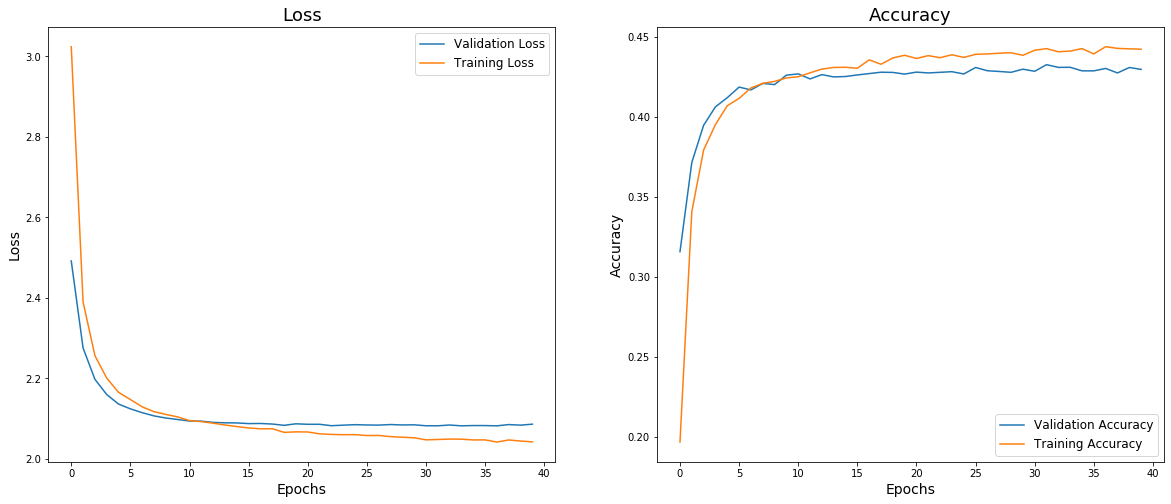

In [27]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(sc_baseline_results)

In [28]:
# Evaluate the training results
sc_baseline_train = sc_baseline_model.evaluate(sc_X_train, sc_train_y)
sc_baseline_train

1908/1908 [==============================] - 2s 1ms/step - loss: 1.9478 - acc: 0.4735


[1.9478094577789307, 0.4735143780708313]

In [29]:
# Evaluate the test results
sc_baseline_test = sc_baseline_model.evaluate(sc_X_test, sc_test_y)
sc_baseline_test

597/597 [==============================] - 1s 1ms/step - loss: 2.0892 - acc: 0.4318


[2.0892269611358643, 0.4318360388278961]

#### Baseline model for the Ultrasuite dataset

In [31]:
# Create baseline model for Ultrasuite dataset
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_baseline_model = build_baseline_model(us_input_shape, us_output_units, learning_rate=0.0001)

# Fit model
us_epochs = 40
us_batch_size = 32
us_patience = 5
us_baseline_results = fit_model(us_baseline_model, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 572)               2288      
_________________________________________________________________
dense_4 (Dense)              (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
110/124 [=========================>....] - ETA: 0s - l

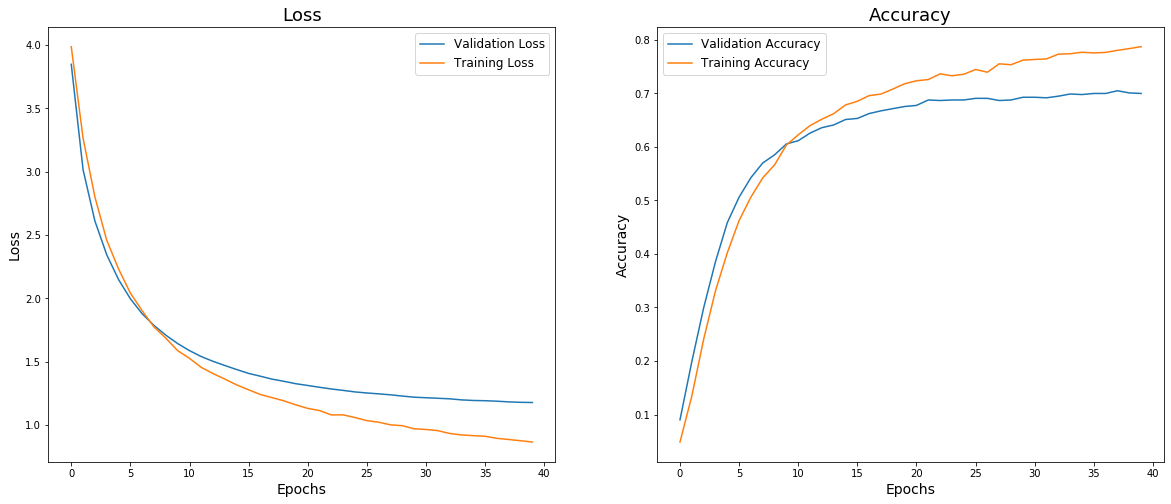

In [32]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(us_baseline_results)

In [33]:
# Evaluate the training results
us_baseline_results_train = us_baseline_model.evaluate(us_X_train, us_train_y)
us_baseline_results_train

124/124 [==============================] - 0s 1ms/step - loss: 0.7920 - acc: 0.8108


[0.7920032143592834, 0.8107559680938721]

In [34]:
# Evaluate the test results
us_baseline_results_test = us_baseline_model.evaluate(us_X_test, us_test_y)
us_baseline_results_test

39/39 [==============================] - 0s 2ms/step - loss: 1.2501 - acc: 0.6748


[1.2501418590545654, 0.6747769713401794]

#### Conclusion

It's starting point with the training accuracy for the Ultrasuite dataset being 81%. The model is clearly overfitting the training data and is not generalising well when shown unseen data given the validation accuracy of just over 67%.

What is of particular note is the vastly different accuracies when compared to the Speech Commands dataset which are both under 50%.  

This could suggest that a more simple model works better for audio samples from children with a speech sound disorder.

<a name="model-2"></a>
### 3C. Model 2: Baseline model with increased learning rate and batch size

In [36]:
# Create second baseline model on Ultrasuite dataset changing the learning rate and batch size
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_baseline_model_2 = build_baseline_model(us_input_shape, us_output_units, learning_rate=0.001)

 
# Fit model
us_epochs = 40
us_batch_size = 64
us_patience = 5
us_baseline_results_2 = fit_model(us_baseline_model_2, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 572)               2288      
_________________________________________________________________
dense_6 (Dense)              (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/62 [=======================>......] - ETA: 0s - los

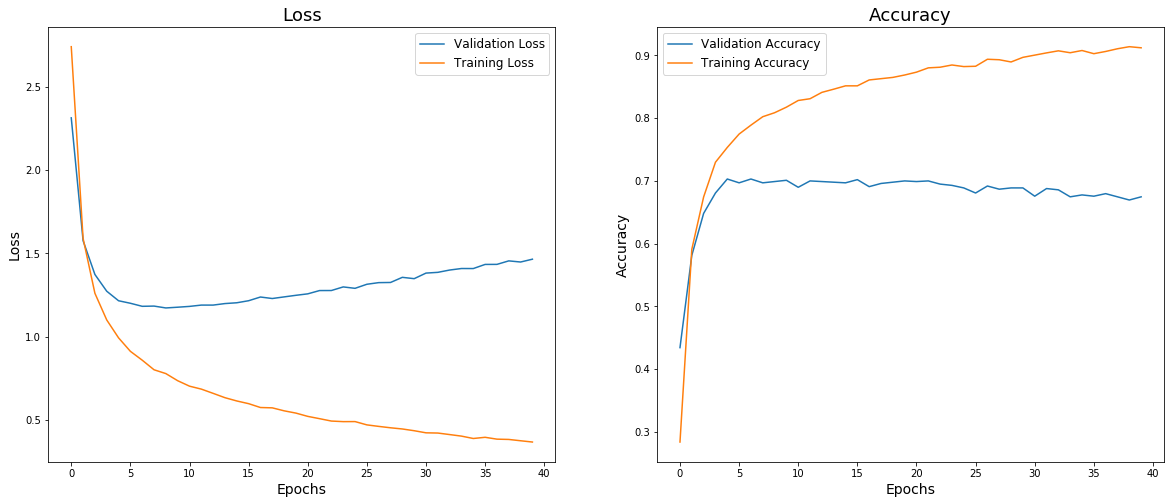

In [37]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(us_baseline_results_2)

In [38]:
# Evaluate the training results
us_baseline_results_2_train = us_baseline_model_2.evaluate(us_X_train, us_train_y)
us_baseline_results_2_train

124/124 [==============================] - 0s 1ms/step - loss: 0.2870 - acc: 0.9439


[0.2869826853275299, 0.9439370632171631]

In [39]:
# Evaluate the test results
results_3_test = us_baseline_model_2.evaluate(us_X_test, us_test_y)
results_3_test

39/39 [==============================] - 0s 2ms/step - loss: 1.5570 - acc: 0.6529


[1.5570393800735474, 0.6528791785240173]

#### Conclusion

We have improved the training accuracy of the baseline model, to over 94%, by increasing the learning rate and increasing the batch size but this has only served to exascerbate the issue of overfitting with test accuracy not reducing to 65% and the difference between the two plots being dramatic.

In an effort to deal with the issue of overfitting, we will introduce some regularization layers and see what effect they have on performance.

<a name="model-3"></a>
### 3D. Model 3: Adding hidden layers to the baseline model, deepening the network

In [95]:
# Build a second baseline model
def build_model_2(input_shape, output_units, loss_func='categorical_crossentropy', learning_rate=0.0001):
    
    model_2 = tf.keras.models.Sequential()
    model_2.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model_2.add(tf.keras.layers.Flatten())
    model_2.add(tf.keras.layers.BatchNormalization())
    model_2.add(tf.keras.layers.Dense(256, activation='relu'))
#     model_2.add(tf.keras.layers.Dropout(0.3))
    model_2.add(tf.keras.layers.Dense(128, activation='relu'))
    model_2.add(tf.keras.layers.Dense(64, activation='relu'))
    model_2.add(tf.keras.layers.Dense(output_units, activation='softmax'))
    
    # Set optimizer and learning rate
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the baseline model
    model_2.compile(loss=loss_func,
                           optimizer=optimiser,
                           metrics=['acc'])

    # Print summary for model
    model_2.summary()
    
    return model_2

In [96]:
# Create baseline model for Ultrasuite dataset
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_model_2 = build_model_2(us_input_shape, us_output_units, learning_rate=0.0001)

# Fit model
us_epochs = 40
us_batch_size = 64
us_patience = 3
us_results_3 = fit_model(us_model_2, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 572)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 572)               2288      
_________________________________________________________________
dense_41 (Dense)             (None, 256)               146688    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_44 (Dense)             (None, 35)                2275      
Total params: 192,403
Trainable params: 191,259
Non-trainable params: 1,144
___________________________________________

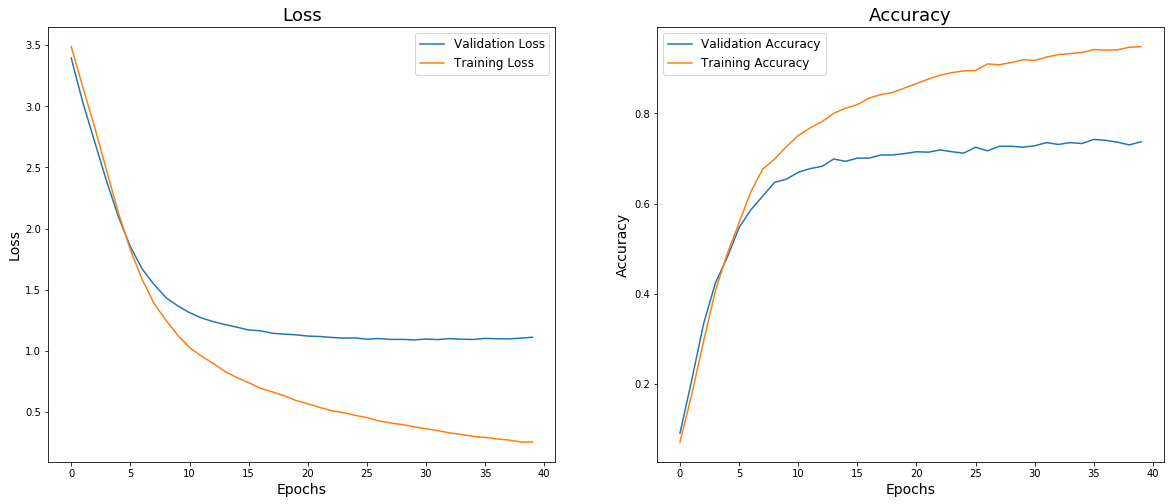

In [97]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(us_results_3)

In [98]:
# Evaluate the training results
us_results_3_train = us_model_2.evaluate(us_X_train, us_train_y)
us_results_3_train

124/124 [==============================] - 0s 2ms/step - loss: 0.1969 - acc: 0.9609


[0.1969350427389145, 0.9609335064888]

In [99]:
# Evaluate the test results
results_4_test = us_model_2.evaluate(us_X_test, us_test_y)
results_4_test

39/39 [==============================] - 0s 2ms/step - loss: 1.0700 - acc: 0.7137


[1.0699917078018188, 0.7137064337730408]

<a name="model-4"></a>
### 3E. Model 4: Convolutional Neural Network

In [100]:
# Build a CNN model

def build_cnn_model(input_shape, output_units, loss='categorical_crossentropy', learning_rate=0.0001):

    cnn_model = tf.keras.models.Sequential()

    # 1st convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), 
                                         activation='relu', 
                                         input_shape=input_shape,
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # 2nd convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(32, (4, 4), 
                                     activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), 
                                         activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # Flatten output and feed into dense layer
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # Softmax output layer
    cnn_model.add(tf.keras.layers.Dense(output_units, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    cnn_model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=['acc'])

    # Print summary for model
    cnn_model.summary()

    return cnn_model

In [50]:
# Create CNN model using Speech Commands MFCCs
sc_cnn_input_shape = (sc_X_train.shape[1], sc_X_train.shape[2], 1)
sc_output_units = 35
sc_cnn_model = build_cnn_model(sc_cnn_input_shape, sc_output_units, learning_rate=0.0001)

 
# Fit model to Speech Commands data
sc_epochs = 40
sc_batch_size = 64
sc_patience = 3
sc_cnn_results = fit_model(sc_cnn_model, 
                      sc_epochs, 
                      sc_batch_size, 
                      sc_patience, 
                      sc_X_train, 
                      sc_train_y, 
                      sc_X_val, 
                      sc_val_y)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 32)         

954/954 [==============================] - 66s 70ms/step - loss: 0.3099 - acc: 0.9324 - val_loss: 0.5104 - val_acc: 0.8787


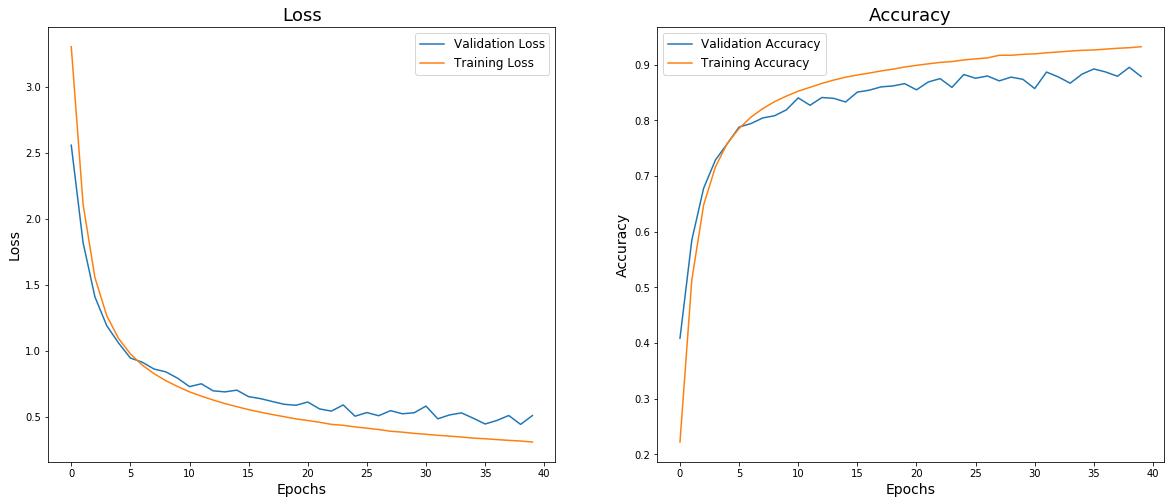

In [51]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(sc_cnn_results)

In [52]:
# Evaluate the training results
sc_cnn_results_train = sc_cnn_model.evaluate(sc_X_train, sc_train_y)
sc_cnn_results_train

1908/1908 [==============================] - 17s 9ms/step - loss: 0.3492 - acc: 0.9178


[0.34924957156181335, 0.9178405404090881]

In [53]:
# Evaluate the test results
sc_cnn_results_test = sc_cnn_model.evaluate(sc_X_test, sc_test_y)
sc_cnn_results_test

597/597 [==============================] - 5s 9ms/step - loss: 0.5155 - acc: 0.8779


[0.5155156254768372, 0.877928614616394]

In [101]:
# Create CNN model using Ultrasuite MFCCs
us_cnn_input_shape = (us_X_train.shape[1], us_X_train.shape[2], 1)
us_output_units = 35
us_cnn_model = build_cnn_model(us_cnn_input_shape, us_output_units, learning_rate=0.0001)

 
# Fit model to Ultrasuite data
us_epochs = 50
us_batch_size = 64
us_patience = 3
us_cnn_results = fit_model(us_cnn_model, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 42, 11, 32)        320       
_________________________________________________________________
batch_normalization_29 (Batc (None, 42, 11, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 6, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 18, 3, 32)         16416     
_________________________________________________________________
batch_normalization_30 (Batc (None, 18, 3, 32)         128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 2, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 1, 64)        

Epoch 41/50
62/62 [==============================] - 2s 39ms/step - loss: 0.9572 - acc: 0.8473 - val_loss: 1.4518 - val_acc: 0.7039
Epoch 42/50
62/62 [==============================] - 3s 40ms/step - loss: 0.9365 - acc: 0.8488 - val_loss: 1.4399 - val_acc: 0.7049
Epoch 43/50
62/62 [==============================] - 3s 44ms/step - loss: 0.9141 - acc: 0.8557 - val_loss: 1.4391 - val_acc: 0.7059
Epoch 44/50
62/62 [==============================] - 3s 46ms/step - loss: 0.9025 - acc: 0.8579 - val_loss: 1.4313 - val_acc: 0.7140
Epoch 45/50
62/62 [==============================] - 3s 40ms/step - loss: 0.8831 - acc: 0.8643 - val_loss: 1.4143 - val_acc: 0.7089
Epoch 46/50
62/62 [==============================] - 3s 49ms/step - loss: 0.8629 - acc: 0.8688 - val_loss: 1.4154 - val_acc: 0.7191
Epoch 47/50
62/62 [==============================] - 3s 43ms/step - loss: 0.8478 - acc: 0.8699 - val_loss: 1.3989 - val_acc: 0.7211
Epoch 48/50
62/62 [==============================] - 2s 40ms/step - loss: 0.

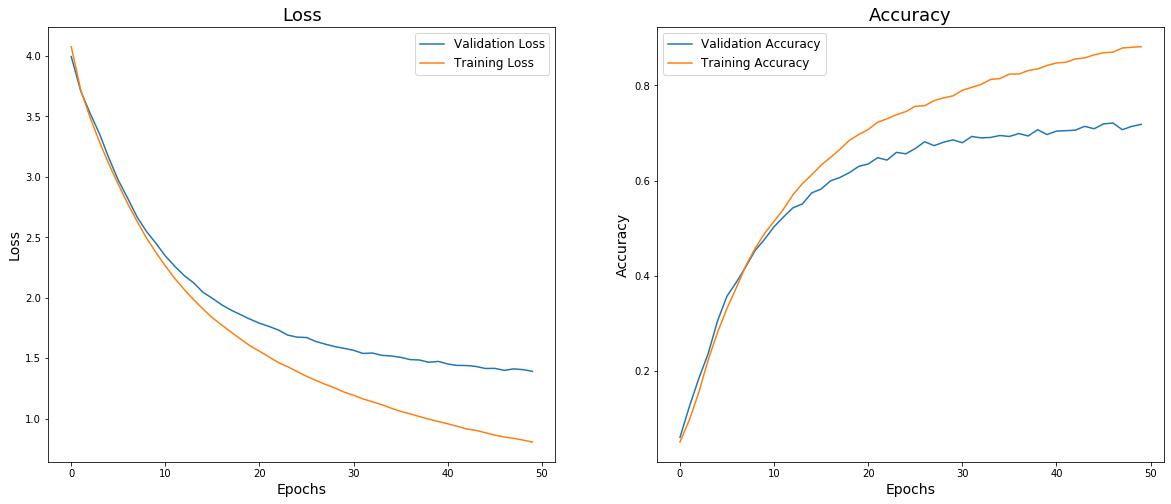

In [102]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(us_cnn_results)

In [103]:
# Evaluate the training results
us_cnn_results_train = us_cnn_model.evaluate(us_X_train, us_train_y)
us_cnn_results_train

124/124 [==============================] - 1s 5ms/step - loss: 0.7748 - acc: 0.8975


[0.7748293280601501, 0.8975139260292053]

In [104]:
# Evaluate the test results
us_cnn_results_test = us_cnn_model.evaluate(us_X_test, us_test_y)
us_cnn_results_test

39/39 [==============================] - 0s 5ms/step - loss: 1.4257 - acc: 0.7064


[1.4257444143295288, 0.7064071297645569]

#### Running the models using Mel Spectrograms instead of MFCCs

A thought exercise more than anything else, just to see if there are any performance gains that can be made by using Mel Spectrograms instead of MFCCs.

In [62]:
# Set the parameters for the Ultrasuite dataset for preprocessing based on Mel Spectrograms
us_dataset_path = 'data/ultrasuite_top35'
us_melspec_json_path = 'ultrasuite_top35_data_melspec.json'
num_samples = 22050

In [ ]:
# Preprocess the Ultrasuite dataset
preprocess_dataset(us_dataset_path, us_melspec_json_path, 'mel_specs', num_samples)

In [66]:
# Create the train, test and validation datasets for the Ultrasuite Top 40 dataset using MFCCs
us_data_path = 'ultrasuite_top35_data_melspec.json'
X_train_mel, y_train_mel, X_val_mel, y_val_mel, X_test_mel, y_test_mel = create_train_test(us_data_path, 'mel_specs')

Datasets loaded...


In [67]:
# Create CNN model using MFCCs
us_mel_input_shape = (X_train_mel.shape[1], X_train_mel.shape[2], 1)
us_mel_output_units = 35
us_mel_model = build_model_2(us_mel_input_shape, us_mel_output_units, learning_rate=0.0001)

# One-hot encode Speech Commands labels
mel_train_y = reformat_y(y_train_mel)
mel_test_y = reformat_y(y_test_mel)
mel_val_y = reformat_y(y_val_mel)

# Fit model
us_mel_epochs = 40
us_mel_batch_size = 64
us_mel_patience = 3
us_mel_results = fit_model(us_mel_model, us_mel_epochs, us_mel_batch_size, us_mel_patience, X_train_mel, mel_train_y, X_val_mel, mel_val_y)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 5632)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 5632)              22528     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               1442048   
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 35)                2275      
Total params: 1,508,003
Trainable params: 1,496,739
Non-trainable params: 11,264
______________________________________

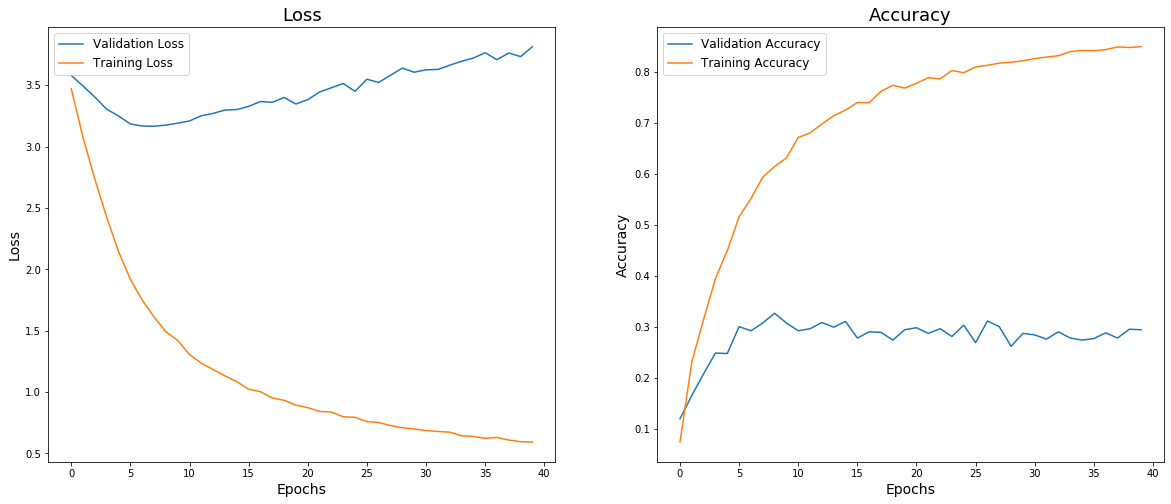

In [68]:
# Visualise the loss and accuracy of the training and validation sets across epochs
visualise_results(us_mel_results)

<a name="final-model-performance-evaluation"></a>
### 3F. Final Model Performance Evaluation

In [157]:
# Import necessary libraries for performance evaluation.
from sklearn.metrics import accuracy_score, confusion_matrix

# Create predictions
preds = us_cnn_model.predict(us_X_test)



# Calculate accuracy and confusion matrix
acc = accuracy_score(us_test_y, np.round(preds))*100
cm = confusion_matrix(us_test_y.argmax(axis=1), np.round(preds.argmax(axis=1)))

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
print('Loss: {}'.format(us_cnn_results_test[0]))
print('Accuracy: {}%'.format(np.round(us_cnn_results_test[1]*100), 2))


print('\nTRAIN METRICS ----------------------')
print('Loss: {}'.format(us_cnn_results_train[0]))
print('Accuracy: {}%'.format(np.round(us_cnn_results_train[1]*100), 2))

CONFUSION MATRIX ------------------
[[16  1  0 ...  0  1  0]
 [ 0 35  0 ...  0  1  0]
 [ 1  0 21 ...  0  0  0]
 ...
 [ 2  1  0 ... 20  1  1]
 [ 0  3  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 16]]

TEST METRICS ----------------------
Loss: 1.4257444143295288
Accuracy: 71.0%

TRAIN METRICS ----------------------
Loss: 0.7748293280601501
Accuracy: 90.0%


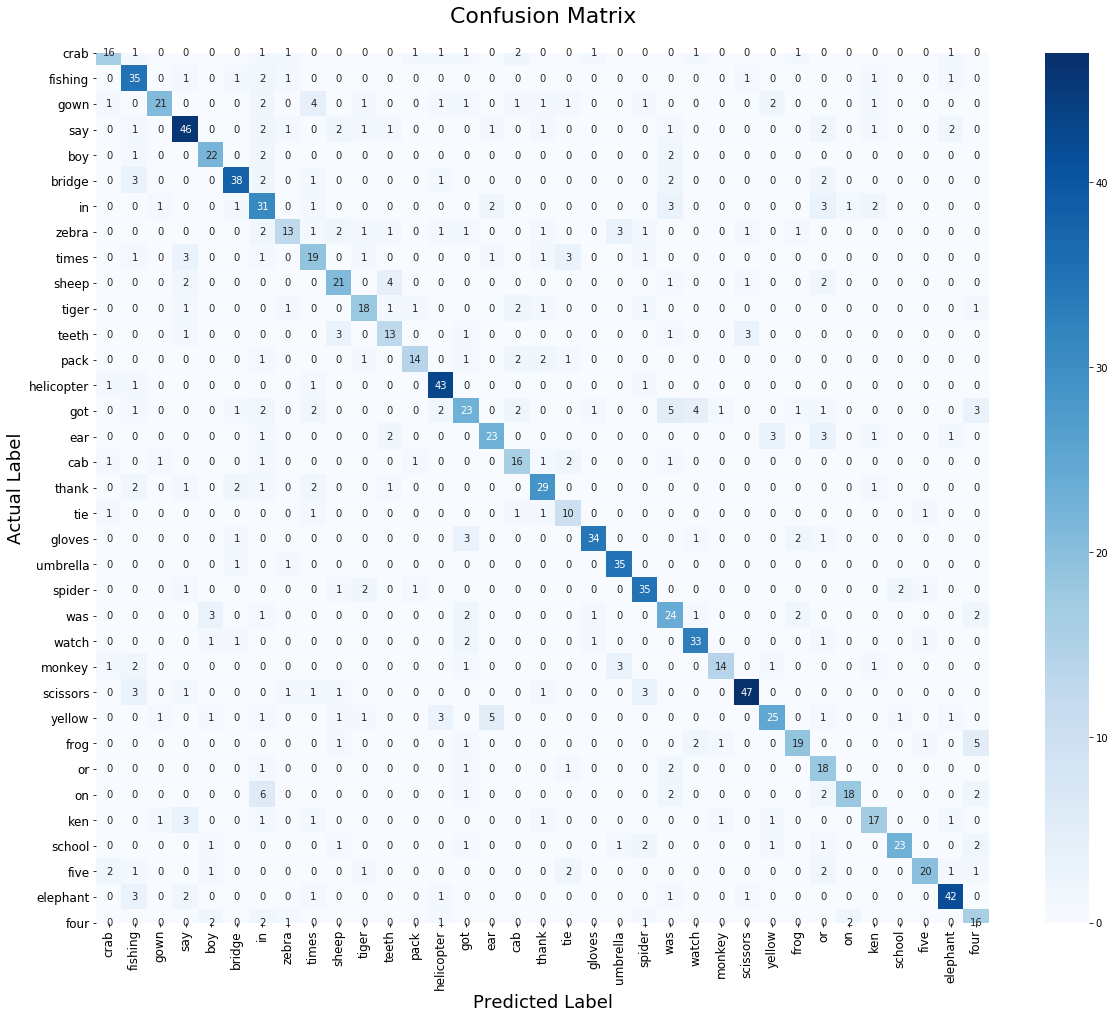

In [225]:
# Use Seaborn to make the confusion matrix more visually presentable
plt.figure(figsize=(20,16))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

us_keywords = [
    'crab',
    'fishing',
    'gown',
    'say',
    'boy',
    'bridge',
    'in',
    'zebra',
    'times',
    'sheep',
    'tiger',
    'teeth',
    'pack',
    'helicopter',
    'got',
    'ear',
    'cab',
    'thank',
    'tie',
    'gloves',
    'umbrella',
    'spider',
    'was',
    'watch',
    'monkey',
    'scissors',
    'yellow',
    'frog',
    'or',
    'on',
    'ken',
    'school',
    'five',
    'elephant',
    'four']

ax.set_title('Confusion Matrix', fontsize=22, pad=30)
ax.set_xlabel('Predicted Label', fontsize=18)
ax.set_ylabel('Actual Label', fontsize=18)
ax.xaxis.set_ticklabels(us_keywords, rotation=90, fontsize=12)
ax.yaxis.set_ticklabels(us_keywords, rotation=0, fontsize=12)
plt.show();

In [268]:
# Load the audio sample and preview
target_sample = 'audio/martha-frog.wav'
target_label = 'Frog'
audio_sample, sr = librosa.load(target_sample)
print('Audio sample:', target_label)
ipd.Audio(audio_sample, rate=sr)

Audio sample: Frog


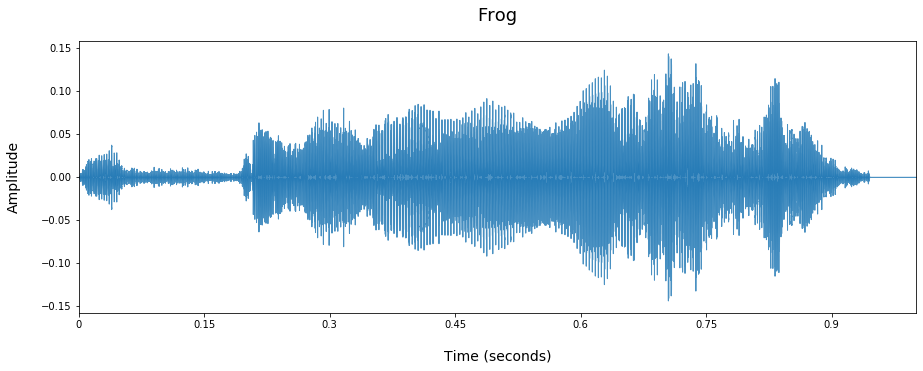

In [269]:
# Plot the waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title(target_label, fontsize=18, pad=20)
librosa.display.waveplot(audio_sample, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

In [270]:
# Run inference on the unseen audio file
mfccs = librosa.feature.mfcc(audio_sample, sr, n_mfcc=13, n_fft=2048, hop_length=512)
mfccs = mfccs.T
mfccs = mfccs[np.newaxis, ..., np.newaxis]

prediction = us_cnn_model.predict(mfccs)
predicted_index = np.argmax(prediction)

predicted_keyword = us_keywords[predicted_index]
print('Martha says...',predicted_keyword, '!')

Martha says... frog !


#### Conclusion

Initial models did not generalise well and tended to overfit the training data. Subsequent changes to parameters significantly improved the training accuracy but, again were overfitting the training data.

Whilst it does not have a high accuracy score, this final model using a Convolutional Neural Network and data augmentation produced the best results classifying 70% of the “unseen” audio samples.

The very nature of speech sound disorders mean that a model that has been simply trained on audio samples of "typical" speech will generally be more accurate than one that has been trained on audio samples of "atypical" speech as demonstrated above with the model comparison between the Speech Commands and Ultrasuite datasets.

Given the eventual usage of this model, it is arguable the app would be more useful if it suggested three potential words in order of likelihood, giving the parent options of what the child might be trying to communicate.

Additional data and further manipulation of the architecture of Convolutional Neural Network could also potentially improve accuracy but also utilising data augmentation techniques such as [MixSpeech](https://arxiv.org/abs/2102.12664) that could take a weighted combination of mel-spectrograms and MFCC in order to improve model performance.

<hr size="1" />
<small>
<strong>Sources / Code adapted from:</strong><br/>
    * <a href="https://www.tensorflow.org/tutorials/audio/simple_audio" target="_new">Simple audio recognition: Recognizing keywords - Tensorflow</a><br/>
    * <a href="https://github.com/musikalkemist/Deep-Learning-Audio-Application-From-Design-to-Deployment" target="_new">Deep Learning Audio Application from Design to Deployment - Valerio Velardo - The Sound of AI</a><br/>
</small>